In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import time
import shutil
sys.path.insert(0, '../..')

from database.dataset import INBreast_Dataset
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria
from candidate_proposal.morphology_mc import MorphologyCalcificationDetection
from candidate_proposal.hdog_mc import HDoGCalcificationDetection
from candidate_proposal.hough_mc import HoughCalcificationDetection

from tqdm import tqdm
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
from pathlib import Path

import warnings
import seaborn as sns
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### Define experiment runers

Morphology

In [2]:
def run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle):
    normal_ids = db.get_free_of_selected_lesions_imgs_ids()

    m_results_path = results_path / 'morphology'
    m_results_path.mkdir(exist_ok=True, parents=True)

    rbd_path = m_results_path / 'recounstructed_by_dialation_img'
    if rbd_path.exists():
        shutil.rmtree(rbd_path)
    rbd_path.mkdir(exist_ok=True, parents=True)

    result_det = {}
    res = []
    for idx in tqdm(range(len(db)), total=len(db)):
        case = db[idx]
        image = case['img']
        image_id = case['img_id']
        lesion_mask = case['lesion_mask']
        if filter_muscle:
            muscle_mask = case['muscle_mask']

        md = MorphologyCalcificationDetection(
            rbd_path, threshold=threshold, min_distance=min_distance,
            area=area*area, store_intermediate=False, filter_muscle_region=filter_muscle)

        start = time.time()
        if filter_muscle:
            candidate_blobs = md.detect(image, image_id, muscle_mask)
        else:
            candidate_blobs = md.detect(image, image_id)
        t = time.time() - start

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(
            candidate_blobs, lesion_mask, None, 14, use_euclidean_dist=True)
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}

        res.append(img_res)
        result_det[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}
    results_morphology = pd.DataFrame(res)
    filename = f'md_th-{threshold}_mindist-{min_distance}_area-{area}'
    results_morphology.to_csv(results_path/f'{filename}.csv')
    with open(results_path/f'{filename}.pkl', 'wb') as f:
        pickle.dump(result_det, f)

HDoG

In [3]:
def run_experiment_hdog(dog_parameters, hessian_parameters, db, results_path, filter_muscle):
    
    normal_ids = db.get_free_of_selected_lesions_imgs_ids()
    
    hdog_results_path = results_path / 'HDoG'
    hdog_results_path.mkdir(exist_ok=True, parents=True)

    processed_imgs_path = hdog_results_path / 'hdog_images'
    if processed_imgs_path.exists():
        shutil.rmtree(processed_imgs_path)
    processed_imgs_path.mkdir(exist_ok=True, parents=True)

    detections_path = hdog_results_path / 'hdog_detections'
    if processed_imgs_path.exists():
        shutil.rmtree(processed_imgs_path)
    if detections_path.exists():
        shutil.rmtree(detections_path)
    detections_path.mkdir(exist_ok=True, parents=True)

    result_det = {}
    res = []

    for idx in tqdm(range(len(db)), total=len(db)):
        case = db[idx]
        image = case['img']
        image_id = case['img_id']
        lesion_mask = case['lesion_mask']
        if filter_muscle:
            muscle_mask = case['muscle_mask']

        hdogd = HDoGCalcificationDetection(
            dog_parameters, hessian_parameters, processed_imgs_path, detections_path,
            filter_muscle_region=filter_muscle)
        
        start = time.time()
        if filter_muscle:
            detections = hdogd.detect(image, image_id, False, False, muscle_mask)
        else:
            detections = hdogd.detect(image, image_id, False, False)
        t = time.time() - start

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(
            detections, lesion_mask, None, 14, use_euclidean_dist=True)
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}

        res.append(img_res)
        result_det[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}

    results_hdog = pd.DataFrame(res)

    ms = dog_parameters['min_sigma']
    Ms = dog_parameters['max_sigma']
    ns = dog_parameters['n_scales']
    ns = dog_parameters['n_scales']
    dth = dog_parameters['dog_blob_th']
    dovp = dog_parameters['dog_overlap']
    dmd = dog_parameters['dog_min_dist']
    filename = f'hdog_ms-{ms}_Ms-{Ms}_ns-{ns}_dth-{dth}_dovp-{dovp}_dmd-{dmd}'
    results_hdog.to_csv(results_path/f'{filename}.csv')
    with open(results_path/f'{filename}.pkl', 'wb') as f:
        pickle.dump(result_det, f)

Hough

In [4]:
def run_experiment_hough(
    dehazing_params, hough1_params, hough2_params, back_ext_radius,
    erosion_iter, erosion_size, min_hough2_distance, db, results_path, filter_muscle
):
    normal_ids = db.get_free_of_selected_lesions_imgs_ids()

    hough_results_path = results_path / 'Hough'
    hough_results_path.mkdir(exist_ok=True, parents=True)

    processed_imgs_path = hough_results_path / 'hough_images'
    if processed_imgs_path.exists():
        shutil.rmtree(processed_imgs_path)
    processed_imgs_path.mkdir(exist_ok=True, parents=True)

    result_det_h1 = {}
    result_det_h2 = {}
    res_h1 = []
    res_h2 = []

    for idx in tqdm(range(len(db)), total=len(db)):
        case = db[idx]
        image = case['img']
        image_id = case['img_id']
        lesion_mask = case['lesion_mask']
        if filter_muscle:
            muscle_mask = case['muscle_mask']

        hd = HoughCalcificationDetection(
            dehazing_params, back_ext_radius, processed_imgs_path, hough1_params, hough2_params,
            erosion_iter=erosion_iter, erosion_size=erosion_size, min_hough2_dist=min_hough2_distance,
            filter_muscle_region=filter_muscle)

        start = time.time()
        if filter_muscle:
            h1_circles, h2_circles = hd.detect(image, image_id,
                load_processed_images=False, hough2=True, muscle_mask=muscle_mask)
        else:
            h1_circles, h2_circles = hd.detect(image, image_id,
                load_processed_images=False, hough2=True)
        t = time.time() - start

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(h1_circles, lesion_mask, None, 14, use_euclidean_dist=True)
        result_det_h1[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res_h1 = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}
        res_h1.append(img_res_h1)

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(h2_circles, lesion_mask, None, 14, use_euclidean_dist=True)
        result_det_h2[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res_h2 = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}
        res_h2.append(img_res_h2)

    results_hough_h1 = pd.DataFrame(res_h1)
    results_hough_h2 = pd.DataFrame(res_h2)

    filename = f'hough_default'
    results_hough_h1.to_csv(results_path/f'{filename}_h1.csv')
    with open(results_path/f'{filename}_h1.pkl', 'wb') as f:
        pickle.dump(result_det_h1, f)

    results_hough_h2.to_csv(results_path/f'{filename}_h2.csv')
    with open(results_path/f'{filename}_h2.pkl', 'wb') as f:
        pickle.dump(result_det_h2, f)

In [39]:
def plot_results(results_path):
    filename = 'md_th-0.95_mindist-6_area-14'
    results_morphology95 = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
    results_morphology95['method'] = 'gs_morph_095'

    filename = 'md_th-0.97_mindist-6_area-14'
    results_morphology = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
    results_morphology['method'] = 'gs_morph_097'

    filename = 'hdog_ms-1_Ms-3_ns-20_dth-0.006_dovp-0.2_dmd-6'#'hdog_ms-1_Ms-3_ns-20_dth-0.006_dmd-6'
    results_hdog = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
    results_hdog['method'] = 'hdog'

    results_hough_h1 = pd.read_csv(results_path/'hough_default_h1.csv', index_col=0)
    results_hough_h1['method'] = 'hough_h1'
    results_hough_h2 = pd.read_csv(results_path/'hough_default_h2.csv', index_col=0)
    results_hough_h2['method'] = 'hough_h2'

    results = pd.concat([results_morphology95, results_morphology, results_hdog, results_hough_h1, results_hough_h2], ignore_index=True)
    results['FPR'] = results['FP'] / (results['FP'] + results['TP_wo_dup'])
    results['mfpi'] = (results['FP'] / len(results)).sum()
    results['sens'] = results['TP'] / (results['TP'] + results['FN'])
    results['sens_wod'] = results['TP_wo_dup'] / (results['TP_wo_dup'] + results['FN'])
    results.loc[~results.normal, 'fp_per_tp'] = results['FP'] / (results['TP_wo_dup'])
    results.loc[(~results.normal) & (results.sens==0), 'fp_per_tp'] = results['FP']
    results.loc[results.normal, 'fp_per_tp'] = results['FP']

    melt_results = pd.melt(results, id_vars=['method'], value_vars=['sens', 'sens_wod'])

    plt.figure(figsize=(10, 4))
    plt.title('Sensitivity vs method')
    sns.boxplot(data=results[(results.TP>0)|(results.FN>0)], x='method', y='sens')
    sns.despine()
    plt.show()
    
    plt.figure(figsize=(15, 8))
    plt.title('Detection sensitivity by method')
    sns.boxplot(data=results[(results.TP>0)|(results.FN>0)], x='method', y='sens_wod')
    plt.grid()
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('Sensitivity comparison')
    sns.boxplot(data=melt_results, x='method', y='value', hue='variable')
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('False positives per tp per image vs method')
    sns.boxplot(data=results, x='method', y='fp_per_tp')
    plt.ylim(0, 2000)
    sns.despine()
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.title('FP per TP per image by method')
    sns.boxplot(data=results, x='method', y='fp_per_tp')
    plt.yscale('log')
    plt.grid()

    sns.despine()
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.title('FP per TP per image on normal images by method')
    sns.boxplot(data=results.loc[results.normal], x='method', y='fp_per_tp')
    # plt.ylim(0, 25000)
    plt.yscale('log')
    plt.grid()
    sns.despine()
    plt.show()

    plt.figure(figsize=(15, 8))
    plt.title('Computation time per image by method')
    sns.boxplot(data=results, x='method', y='time')
    # plt.yscale('log')
    sns.despine()
    plt.ylabel('time [s]')
    plt.ylim([0, 70])
    plt.show()
    
    return results_morphology95, results_morphology, results_hdog, results_hough_h1, results_hough_h2


## Run experiments without pectoral supression and with circular labelling

In [6]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
)

In [7]:
results_path = Path.cwd().parent.parent.parent / 'data/comparisson_between_detectors_w_pectoral/'
results_path.mkdir(exist_ok=True, parents=True)

In [8]:

# GSM
threshold = 0.97
min_distance = 6
area = 14
run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle=False)

threshold = 0.95
min_distance = 6
area = 14
run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle=False)


# HDOG
dog_parameters = {
    'min_sigma': 1,
    'max_sigma': 3,
    'n_scales': 20,
    'sigma_ratio': None,
    'dog_blob_th': 0.006,
    'dog_overlap': 0.2,
    'dog_min_dist': 6,
}

hessian_parameters = {
    'method': 'eigenval',
    'hessian_threshold': None,
    'hessian_th_divider': 300
}

run_experiment_hdog(dog_parameters, hessian_parameters, db, results_path, filter_muscle=False)



# HOUGH

dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 10,
                 'param1': 300, 'param2': 5,  'minRadius': 2, 'maxRadius': 10}
hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 3,  'minRadius': 2, 'maxRadius': 10}

back_ext_radius = 50
erosion_iter = 20
erosion_size = 5
min_hough2_distance = 6
run_experiment_hough(
    dehazing_params, hough1_params, hough2_params, back_ext_radius, erosion_iter,
    erosion_size, min_hough2_distance, db, results_path, filter_muscle=False
)


100%|██████████| 210/210 [1:51:56<00:00, 31.98s/it]


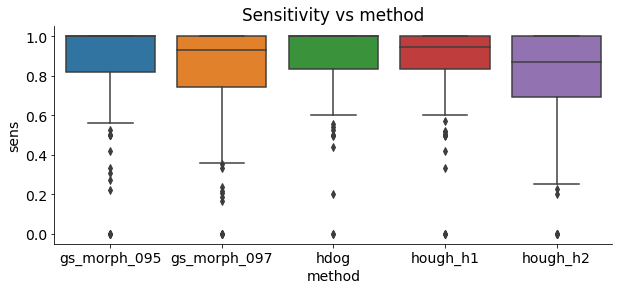

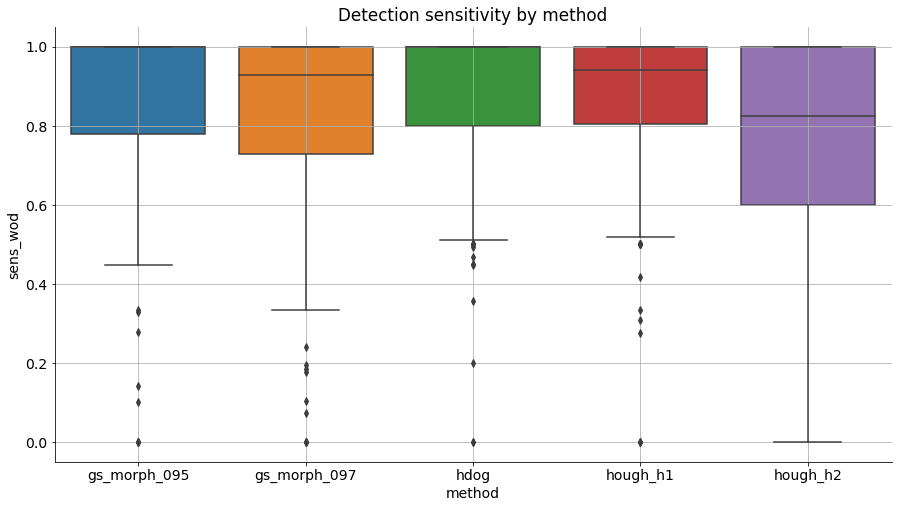

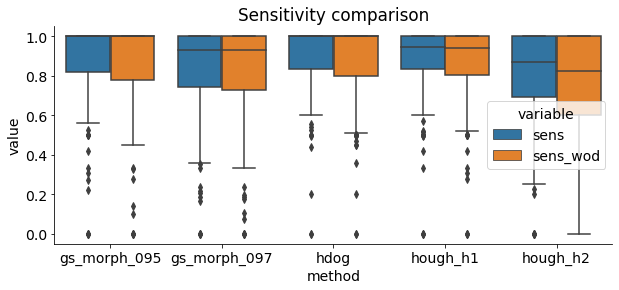

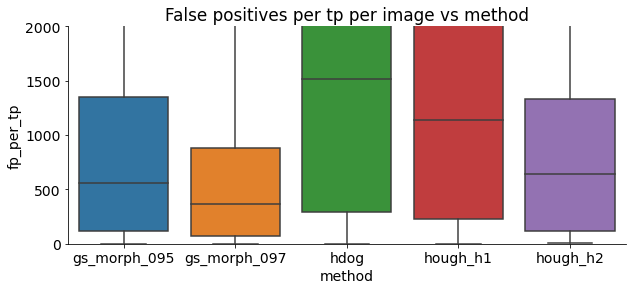

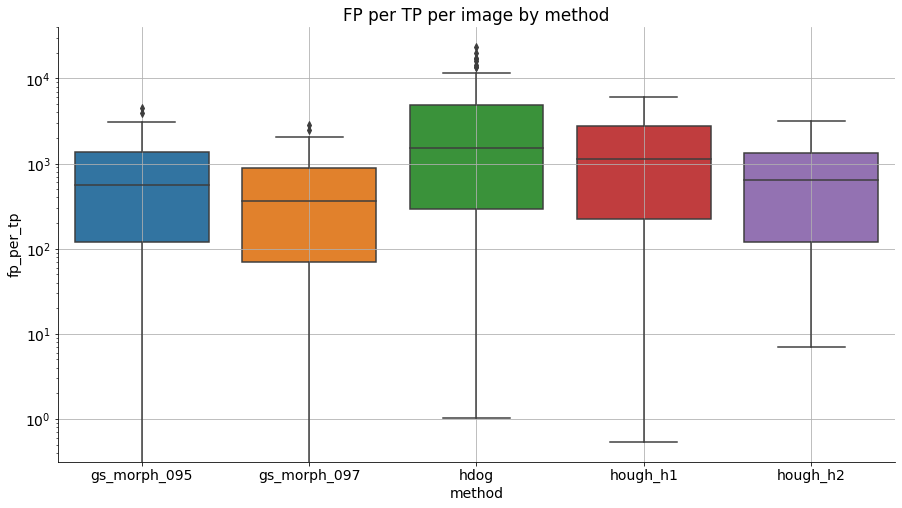

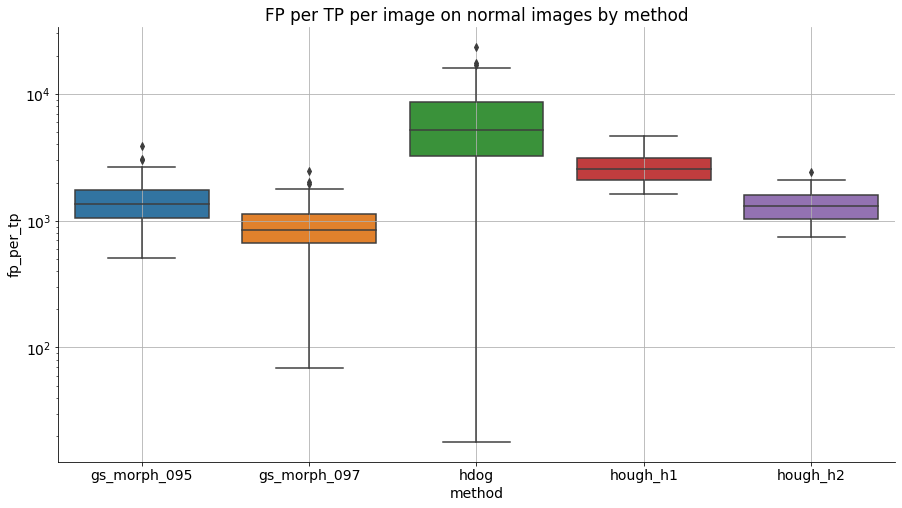

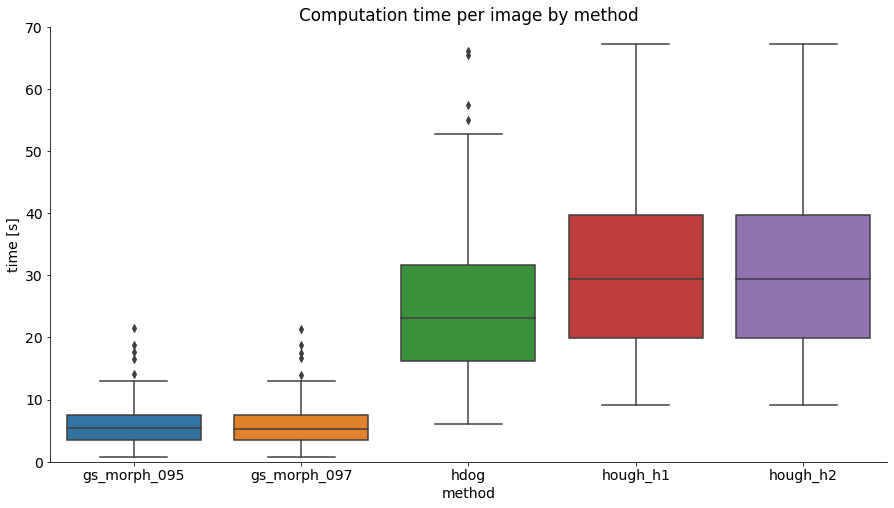

In [40]:
# RESULTS
# remove normals from comparison (they would be sensitivity outliers)
normal_imgs_ids = db.get_normal_imgs_ids()
plt.rcParams.update({'font.size': 14})

results_morphology95, results_morphology, results_hdog, results_hough_h1, results_hough_h2 = plot_results(results_path)

# Looking into badly detected images

In [58]:
merged_res = pd.concat([results_morphology95, results_morphology, results_hdog, results_hough_h1, results_hough_h2])
merged_res

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method
0,20587054,0,0,1046,0,2.559873,False,gs_morph_095
1,20587080,0,0,1600,0,5.588631,False,gs_morph_095
2,20587148,2,2,667,0,1.711426,False,gs_morph_095
3,20587174,11,10,341,0,1.514336,False,gs_morph_095
4,20587200,4,4,1234,0,5.009331,False,gs_morph_095
...,...,...,...,...,...,...,...,...
205,53586896,5,4,2930,0,57.835591,False,hough_h2
206,53587427,2,2,1736,0,33.149352,False,hough_h2
207,53587454,3,3,1909,0,38.100927,False,hough_h2
208,53587481,6,5,1356,1,21.361219,False,hough_h2


## Images for which we didn't have labels (no mC images)

In [56]:
not_detected_imgs = merged_res[(merged_res.TP == 0)&(merged_res.FN == 0)].groupby('img_id')['method'].count().sort_values(ascending=False)
not_detected_imgs

img_id
20587054    5
50996325    5
50996379    5
50996406    5
50997053    5
           ..
50994760    5
50994787    5
50994814    5
50994868    5
53586751    5
Name: method, Length: 61, dtype: int64

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
0,20587054,0,0,1046,0,2.559873,False,gs_morph_095,NaN
0,20587054,0,0,639,0,3.276280,False,gs_morph_097,NaN
0,20587054,0,0,6045,0,16.135415,False,hdog,NaN
0,20587054,0,0,2441,0,23.897782,False,hough_h1,NaN
0,20587054,0,0,1199,0,23.897782,False,hough_h2,NaN


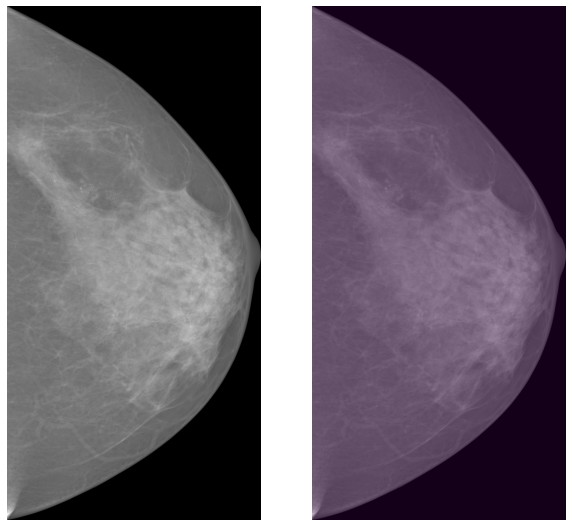

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
139,50996325,0,0,1656,0,5.388119,True,gs_morph_095,NaN
139,50996325,0,0,1021,0,5.428571,True,gs_morph_097,NaN
139,50996325,0,0,2890,0,20.927835,True,hdog,NaN
139,50996325,0,0,2097,0,18.503063,True,hough_h1,NaN
139,50996325,0,0,1049,0,18.503063,True,hough_h2,NaN


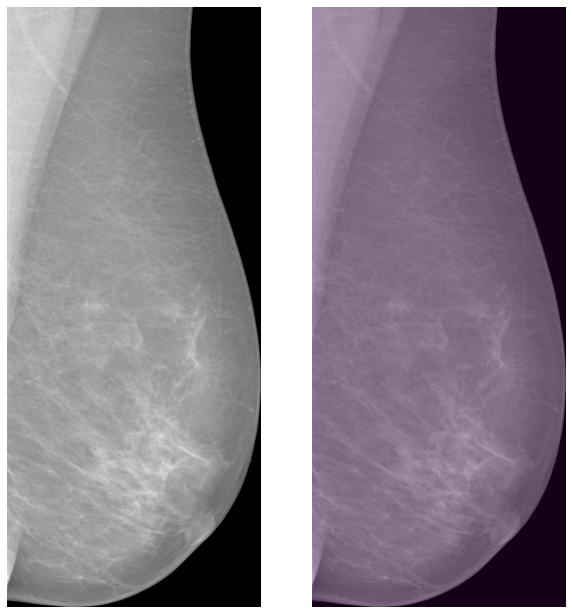

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
141,50996379,0,0,1048,0,3.040641,True,gs_morph_095,NaN
141,50996379,0,0,679,0,3.142367,True,gs_morph_097,NaN
141,50996379,0,0,5163,0,14.553304,True,hdog,NaN
141,50996379,0,0,1896,0,14.882085,True,hough_h1,NaN
141,50996379,0,0,919,0,14.882085,True,hough_h2,NaN


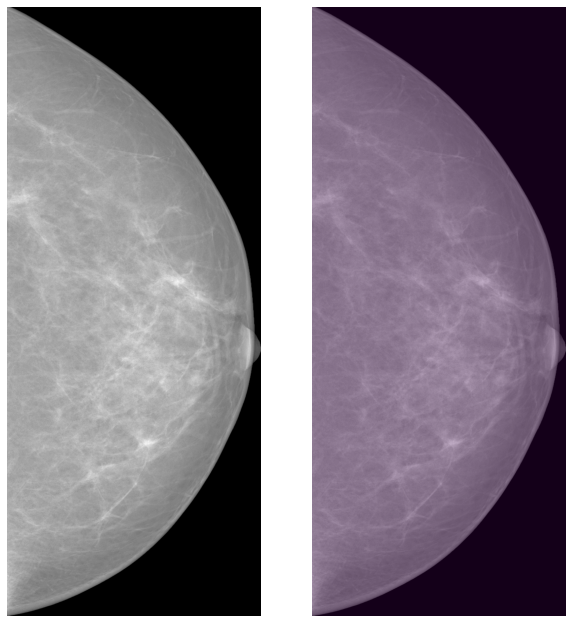

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
142,50996406,0,0,1000,0,3.155177,True,gs_morph_095,NaN
142,50996406,0,0,664,0,3.327973,True,gs_morph_097,NaN
142,50996406,0,0,4856,0,13.603605,True,hdog,NaN
142,50996406,0,0,1613,0,13.481110,True,hough_h1,NaN
142,50996406,0,0,839,0,13.481110,True,hough_h2,NaN


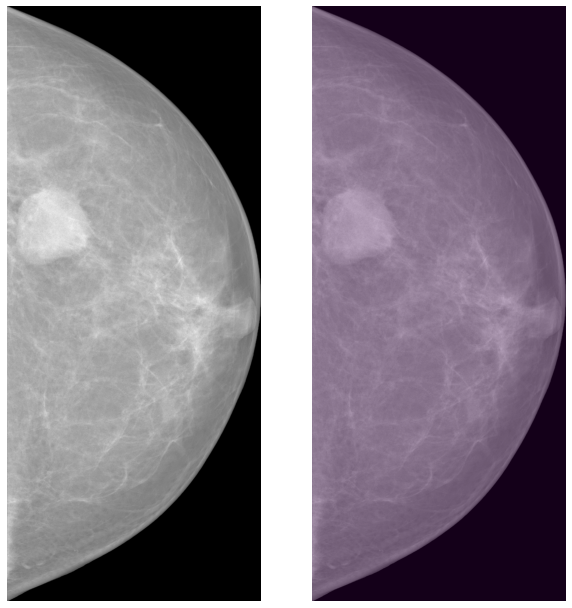

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
149,50997053,0,0,1374,0,4.067682,True,gs_morph_095,NaN
149,50997053,0,0,862,0,3.992608,True,gs_morph_097,NaN
149,50997053,0,0,8590,0,22.649677,True,hdog,NaN
149,50997053,0,0,3314,0,34.053745,True,hough_h1,NaN
149,50997053,0,0,1500,0,34.053745,True,hough_h2,NaN


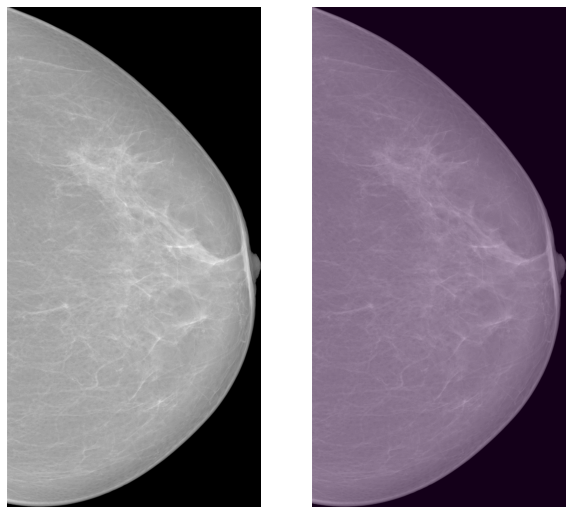

In [57]:
for imgid in not_detected_imgs.index[:5]:
    display(merged_res[merged_res.img_id == imgid])
    idx = db.df[db.df.img_id == imgid].index.values[0]
    img = db[idx]['img']
    mask = db[idx]['lesion_mask']

    plt.figure(figsize=(10,25))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    mask = cv2.dilate(mask, kernel=np.ones((11,11)))
    plt.imshow(img, cmap='gray')
    plt.imshow(mask>0, alpha=0.3)
    plt.axis('off')
    plt.show()

## Images in which we haven't detected any calcificaitons, though some were present

In [ ]:
not_detected_imgs = merged_res[(merged_res.TP == 0)&(merged_res.FN != 0)].groupby('img_id')['method'].count().sort_values(ascending=False)
not_detected_imgs

img_id
20587320    4
26933772    4
26933830    4
53582422    4
53582476    1
53586805    1
Name: method, dtype: int64

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
91,26933772,0,0,366,2,0.793843,False,gs_morph_095,0.0
91,26933772,0,0,208,2,0.762504,False,gs_morph_097,0.0
91,26933772,0,0,1783,2,6.079075,False,hdog,0.0
91,26933772,1,1,1047,1,9.071646,False,hough_h1,0.5
91,26933772,0,0,496,2,9.071646,False,hough_h2,0.0


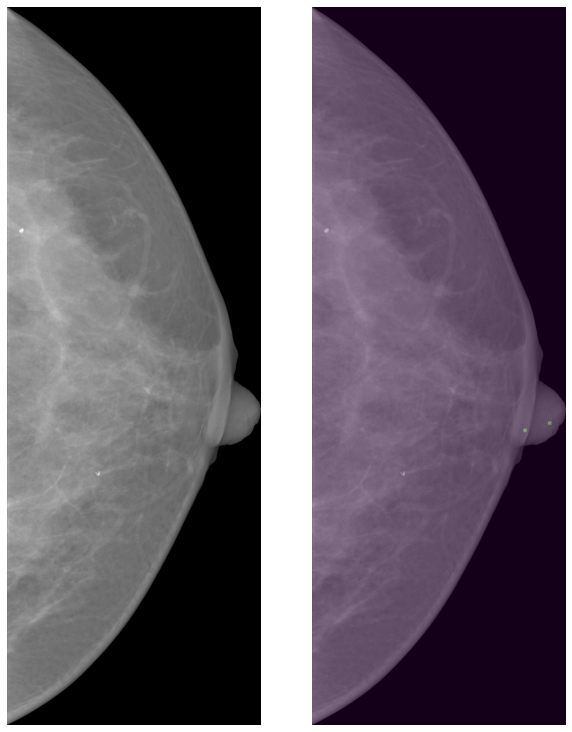

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
7,20587320,0,0,1490,5,5.462356,False,gs_morph_095,0.0
7,20587320,0,0,907,5,5.476190,False,gs_morph_097,0.0
7,20587320,1,1,1672,4,19.398856,False,hdog,0.2
7,20587320,0,0,3083,5,30.762666,False,hough_h1,0.0
7,20587320,0,0,1451,5,30.762666,False,hough_h2,0.0


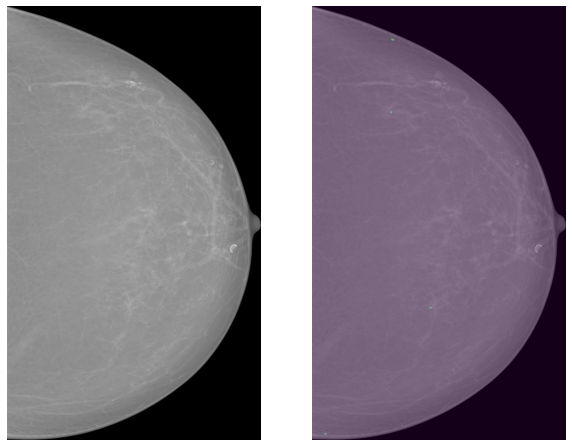

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
113,50993841,34,15,0,92,2.812812,False,gs_morph_095,0.140187
113,50993841,22,11,0,96,2.815801,False,gs_morph_097,0.102804
113,50993841,110,48,49,59,12.239922,False,hdog,0.448598
113,50993841,78,33,22,74,16.973489,False,hough_h1,0.308411
113,50993841,38,15,121,92,16.973489,False,hough_h2,0.140187


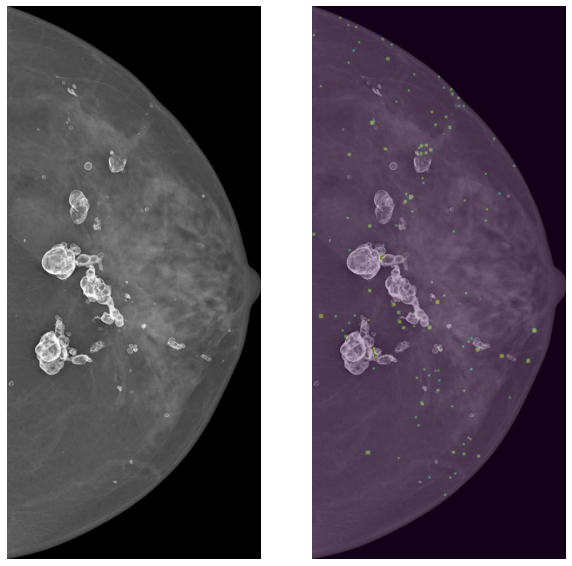

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
117,50993949,28,11,0,98,2.173323,False,gs_morph_095,0.100917
117,50993949,20,8,0,101,2.169311,False,gs_morph_097,0.073394
117,50993949,100,49,57,60,10.820317,False,hdog,0.449541
117,50993949,77,30,26,79,17.064486,False,hough_h1,0.275229
117,50993949,28,13,106,96,17.064486,False,hough_h2,0.119266


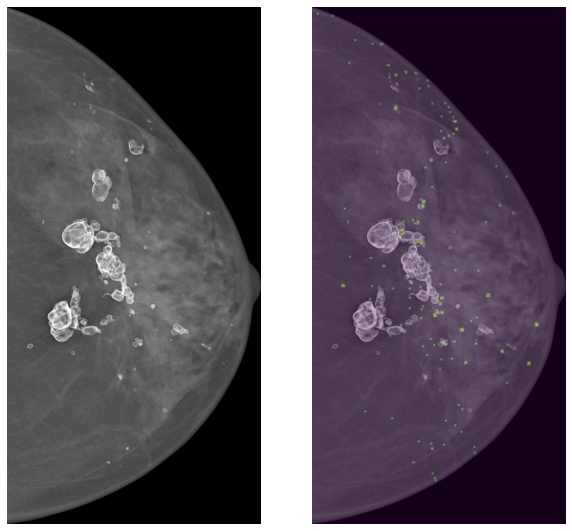

,img_id,TP,TP_wo_dup,FP,FN,time,normal,method,sens_wod
93,26933830,0,0,678,1,1.432129,False,gs_morph_095,0.0
93,26933830,0,0,450,1,1.364518,False,gs_morph_097,0.0
93,26933830,1,1,3489,0,8.811101,False,hdog,1.0
93,26933830,0,0,1585,1,13.266132,False,hough_h1,0.0
93,26933830,0,0,703,1,13.266132,False,hough_h2,0.0


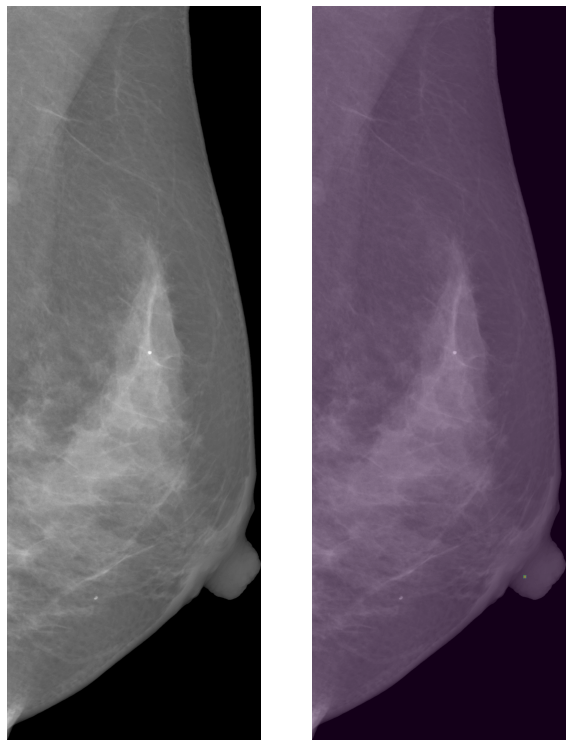

In [65]:
# plotting first 5 examples
for imgid in not_detected_imgs.index[:5]:
    display(merged_res[merged_res.img_id == imgid])
    idx = db.df[db.df.img_id == imgid].index.values[0]
    img = db[idx]['img']
    mask = db[idx]['lesion_mask']

    plt.figure(figsize=(10,25))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    mask = cv2.dilate(mask, kernel=np.ones((11,11)))
    plt.imshow(img, cmap='gray')
    plt.imshow(mask>0, alpha=0.3)
    plt.axis('off')
    plt.show()

## Images with `0 < sensitivity < 0.5`

In [63]:
merged_res['sens_wod'] = merged_res['TP_wo_dup'] / (merged_res['TP_wo_dup'] + merged_res['FN'])

not_detected_imgs = merged_res[merged_res.sens_wod <= 0.5].groupby('img_id')['method'].count().sort_values(ascending=False)
not_detected_imgs

img_id
26933772    5
20587320    5
50993841    5
50993949    5
26933830    4
20587346    4
50993697    4
53582422    4
51048972    3
50993895    3
50993787    3
50993670    3
50996709    3
20587294    3
24065557    3
53582737    3
24065680    2
20587784    2
27829134    2
30011484    2
53582791    2
53582683    2
50993868    2
22670301    2
20587690    2
50998634    1
53582476    1
50996999    1
30011507    1
50993976    1
50993814    1
26933801    1
24065914    1
24065833    1
24065289    1
24065251    1
24055806    1
20587664    1
53586805    1
Name: method, dtype: int64